In [1]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from sklearn.metrics import root_mean_squared_error, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import UNeuralNetwork as nn

In [2]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()

    output = model(x_batch.to('cpu'))
    loss = loss_function(output, y_batch.to('cpu'))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to('cpu'), batch_of_y.to('cpu'), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss / total

def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr=0.001,
            callback=None):
    optima = optimizer(model.parameters(), lr=lr)
    for it in range(count_of_epoch):
        batch_generator = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)
        print(f'Эпоха {it+1}: ошибка = {epoch_loss}') 

def tester(model, dataset, batch_size):
    batch_generator = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size)
    y_predict = []
    y_real = []
    for it, (x_batch, y_batch) in enumerate(batch_generator):
        x_batch = x_batch.to('cpu')
        y_batch = y_batch.to('cpu')

        output = model(x_batch)
        y_predict.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
        y_real.extend(y_batch.cpu().numpy().tolist())
    print(classification_report(y_real, y_predict))    

In [ ]:
#Рекурентные сети
#Задача генерации текста. seq2seq архитектура
#Batch_generator
def batch_generator(dataset, 
                    char2idx, #Каждому символу ставит число(токенизация текста)
                    batch_size=64,
                    shaffle=True):
    X, Y = dataset[:-1], dataset[1:]

    PAD = char2idx['PAD']
    n_samples = len(X)
    
    #Генерируем список индексов
    list_of_indexes = np.linspace(0, n_samples-1, n_samples, dtype=np.int64)
    List_X, List_Y = [], []
    
    if shaffle:
        np.random.shaffle(list_of_indexes)

    #Сделаем новый перемешанный список токенов и тегов
    for idx in list_of_indexes:
        List_X.append(X[idx])
        List_Y.append(Y[idx])

    n_batches = n_samples // batch_size 
    n_batches += (n_samples % batch_size != 0)

    #Выдаем batch'и
    for k in range(n_batches):
        this_batch_size = batch_size
        #Если выдаем последний batch, то его надо обрезать
        if k == n_batches - 1:
            if n_samples % batch_size > 0:
                this_batch_size = n_samples % batch_size
        This_X = List_X[k*batch_size:k*batch_size+this_batch_size]
        This_Y = List_Y[k*batch_size:k*batch_size+this_batch_size]

        This_X_line = [[char2idx.get(char, 0) for char in sent]
                       for sent in This_X]
        This_Y_line = [[char2idx.get('<START>', 0)]
                       +[char2idx.get(char, 0) for char in sent]
                       +[char2idx.get('<FINISH>', 0)]
                       for sent in This_Y]

        List_of_length_X = [len(sent) for sent in This_X_line]
        length_of_sentence_X = max(List_of_length_X)
        List_of_length_Y = [len(sent) for sent in This_Y_line]
        length_of_sentence_Y = max(List_of_length_Y)

        x_arr = np.ones([this_batch_size, length_of_sentence_X]) * PAD
        y_arr = np.ones([this_batch_size, length_of_sentence_Y]) * PAD

        for i in range(this_batch_size):
            x_arr[i, :len(This_X_line[i])] = This_X_line[i]
            x_arr[i, :len(This_Y_line[i])] = This_Y_line[i]

        x = torch.LongTensor(x_arr)
        y = torch.LongTensor(y_arr)
        lengths = torch.LongTensor(List_of_length_X)

        yield x, y


def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr=0.001,
            callback=None):
    optima = optimizer(model.parameters(), lr=lr)
    for it in range(count_of_epoch):
        batch_generator = batch_generator(dataset, char2idx, batch_size)
        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)
        print(f'Эпоха {it+1}: ошибка = {epoch_loss}') 


def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    encoder, decoder = model
    encoder.train()
    encoder.zero_grad()
    decoder.train()
    decoder.zero_grad()

    d, h, c = encoder(x_batch.to(encoder.device))
    output = decoder(y_batch.to(decoder.device),
                     h=h.to(decoder.device)[:,-decoder.num_layers:,:],
                     c=c.to(decoder.device)[:,-decoder.num_layers:,:])
    loss = loss_function(output[:,:-1,:].transpose(1,2), y_batch.to(decoder.device)[:,1:])
    loss.backward()

    optimizer.step()
    return loss.cpu().item()  


def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to('cpu'), batch_of_y.to('cpu'), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss / total

In [2]:
#Создание данных
length = 1000

time = torch.linspace(0,30, length)
data = time / 4 * torch.sin(time) + torch.randn(length)

In [3]:
#Создание X, y
window_size = 20
X = torch.cat([torch.unsqueeze(data[it:it+window_size], 0) for it in range(length-window_size)])
y = torch.tensor([data[it+window_size] for it in range(length-window_size)])

In [4]:
#Создание X_train, y_train, X_test, y_test
split_part = 0.8
index = int(split_part*length)
X_train = X[:index]
y_train = y[:index]
X_test = X[index:]

In [5]:
class rnn_model(torch.nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size):
        super(rnn_model, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size)
        self.lin = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input):
        out, _ = self.rnn(input)
        out = self.lin(out)
        return out.squeeze()

In [6]:
#Создание модели
model = rnn_model(20, 40, 1)
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

In [7]:
#Обучение модели
epochs = 100
model.train()
for _ in range(epochs):
    model.zero_grad()
    output = model(X_train)
    loss = loss_func(output, y_train)
    loss.backward()
    optim.step()

<Axes: xlabel='X', ylabel='Y'>

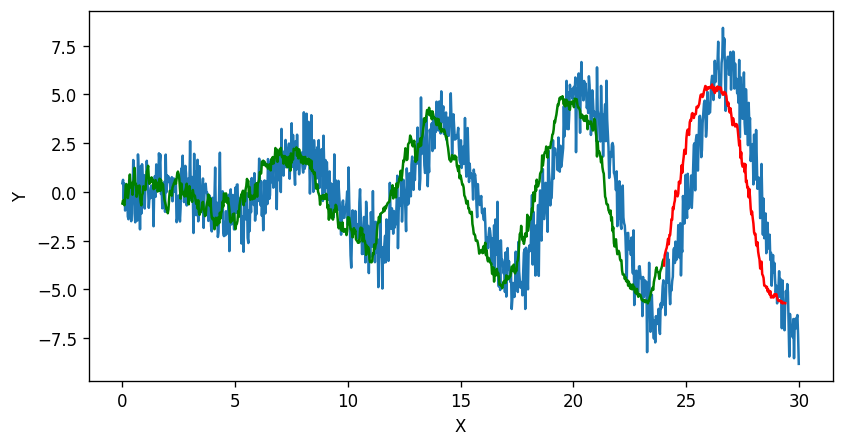

In [8]:
#Результаты
model.eval()
with torch.no_grad():
    y_predict_train = model(X_train)
    y_predict_test = model(X_test)

plt.figure(figsize=(8,4), dpi=120)
plt.xlabel('X')
plt.ylabel('Y')
sns.lineplot(x=time, y=data)
sns.lineplot(x=time[:index], y=y_predict_train, color='green')
sns.lineplot(x=time[index:-window_size], y=y_predict_test, color='red')

In [9]:
class URNN:
    def __init__(self,
                 input_size,
                 hidden_size,
                 bias=True):
        self.input_size = input_size
        self.hidden_size = hidden_size
        weights_generator = nn.UInit(input_size+hidden_size, hidden_size)
        self.weights_h_ = weights_generator.xavier_uniform((hidden_size, hidden_size))
        self.weights_x_ = weights_generator.xavier_uniform((hidden_size, input_size))
        self.bias_h_ = weights_generator.xavier_uniform((hidden_size,)) if bias else None
        self.bias_x_ = weights_generator.xavier_uniform((hidden_size,)) if bias else None

    def __repr__(self):
        return (f'RNN(input_size={self.input_size}, '
                    f'hidden_size={self.hidden_size})')

    def _findDerivativesH(self)

    def _inputStep(self, X, h):
        for x in X:
            h = torch.tanh(self.weights_h_ @ h + self.bias_h_ + self.weights_x_ @ x + self.bias_x_)
            yield torch.unsqueeze(h, dim=0)
            
    def forward(self, X, h=None):
        if h is None:
            h = torch.zeros(self.hidden_size)
        self.derivatives_h_ = torch.zeros((self.hidden_size, hidden_size*hidden_size))
        output = torch.cat(list(self._inputStep(X, h)))
        return output

In [12]:
X = torch.tensor([[2,4,5,3,4],
                  [3,2,4,2,1],
                  [3,4,5,3,2]],
                 dtype=torch.float32)
y = torch.tensor([[-1,3,2,-1,3,-2,-1,2,-3,3],
                  [0,3,-2,1,2,1,-4,3,2,0],
                  [-1,-3,2,-1,2,-3,-4,2,-1,2]],
                 dtype=torch.float32)

In [13]:
rnn_layer = torch.nn.RNN(5, 10)

loss_func = torch.nn.MSELoss()
output, _ = rnn_layer(X)
loss = loss_func(output, y)
loss.backward()

In [14]:
urnn_layer = URNN(5, 10)

urnn_layer.weights_h_ = rnn_layer.weight_hh_l0.detach()
urnn_layer.weights_x_ = rnn_layer.weight_ih_l0.detach()
urnn_layer.bias_h_ = rnn_layer.bias_hh_l0.detach()
urnn_layer.bias_x_ = rnn_layer.bias_ih_l0.detach()

urnn_layer.forward(X)

tensor([[ 0.9287, -0.9126,  0.1367,  0.6627,  0.1044,  0.4628, -0.9785, -0.6456,
         -0.8856,  0.9900],
        [ 0.7139, -0.5896, -0.6627, -0.6369, -0.5842, -0.3681, -0.9063, -0.7390,
         -0.4566,  0.8867],
        [ 0.8261, -0.7796, -0.1041, -0.4492, -0.7567, -0.4787, -0.9785, -0.6046,
         -0.6341,  0.9655]])

In [15]:
output

tensor([[ 0.9287, -0.9126,  0.1367,  0.6627,  0.1044,  0.4628, -0.9785, -0.6456,
         -0.8856,  0.9900],
        [ 0.7139, -0.5896, -0.6627, -0.6369, -0.5842, -0.3681, -0.9063, -0.7390,
         -0.4566,  0.8867],
        [ 0.8261, -0.7796, -0.1041, -0.4492, -0.7567, -0.4787, -0.9785, -0.6046,
         -0.6341,  0.9655]], grad_fn=<SqueezeBackward1>)